### AOTU_fru/dsx+ neurons

Import libraries

In [37]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix


Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[cns].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



# fru/dsx positive neurons from cns data

In [ ]:
cql = f"""
MATCH(n:Neuron)
WHERE (n.type<>'' AND n.type IS NOT NULL AND n.fruDsx<>'')
RETURN distinct n.bodyId AS bodyId, n.instance AS instance, n.type AS type, n.fruDsx AS fruDsx, n.pre AS pre, n.post AS post
"""

In [ ]:
n0 = c.fetch_custom(cql)
n0

In [ ]:
n1, _ = fetch_neurons(NC(type='^AOTU.*'))
n1

In [ ]:
n.fruDsx.value_counts(dropna=False)

In [ ]:
instn0 = n0['instance'].unique()
instn1 = n1['instance'].unique() 

In [ ]:
#  Set connection weight threshold
threshold = 5 #minimum 5 synapses

# Fetch synaptic connectivity between pre and post types
neu_df, conn_df = fetch_adjacencies(sources=NC(instance=instn0), targets=NC(instance=instn1), min_roi_weight=threshold)

# Merge with neuron properties to get types on both sides
conn_all_df = merge_neuron_properties(neu_df, conn_df)

# Group by type combinations and sum the weights by type
conn_inst = conn_all_df.groupby(['instance_pre','instance_post'])['weight'].sum().reset_index()

In [38]:
# Fetch all neurons and get their types
neurons_all_df,roi_all_df = fetch_neurons(NC(type=None)) # Gets all neuron metadata.
#neurons_all_df

In [39]:
all_celltypes = neurons_all_df['type'].unique()
all_celltypes

array(['DNp01', 'OCG01d', 'VCH', ..., 'IN13A073', 'IN19A135', 'IN01B088'],
      dtype=object)

In [40]:
# Filter rows where fruDsx is not None
frudsx_all_neurons = neurons_all_df[neurons_all_df['fruDsx'].notna()]

# Extract the unique cell types from these rows
celltypes_with_frudsx_all = frudsx_all_neurons['type'].dropna().unique().tolist()

In [41]:
print(f"{len(celltypes_with_frudsx_all)} unique cell types with non-null fruDsx:")
print(celltypes_with_frudsx_all)

807 unique cell types with non-null fruDsx:
['LAL138', 'pIP1', 'DNp30', 'DA1_lPN', 'AVLP748m', 'VES074', 'DNp02', 'MeVPMe1', 'VES022', 'SAD051_b', 'MeVPMe2', 'GNG003', 'LAL074', 'AOTU042', 'pC1x_b', 'DNp36', 'DNp19', 'LHPV6q1', 'LT36', 'DNp13', 'FB2F_a', 'mAL_m5a', 'CB4175', 'AL-AST1', 'ALIN1', 'CB4176', 'aIPg9', 'DNp62', 'GNG701m', 'SIP119m', 'LoVC19', 'LC10a', 'DNpe034', 'VES202m', 'PVLP114', 'WED191', 'CRE062', 'AVLP299_b', 'pC1x_c', 'SLP270', 'DC3_adPN', 'IPC', 'LoVC2', 'pMP2', 'SAD051_a', 'AVLP731m', 'PPM1203', 'AVLP732m', 'SAD098', 'SMP285', 'PVLP211m_a', 'AVLP712m', 'GNG700m', 'SLP388', 'pIP10', 'mAL_m3b', 'ORN_VA1v', 'WED189', 'SIP091', 'AOTU103m', 'WED190', 'CB1078', 'VA1v_adPN', 'SIP126m_a', 'AVLP316', 'CB2763', 'SMP586', 'VA1d_adPN', 'AVLP300_a', 'TuTuA_2', 'ALON3', 'LAL073', 'hDeltaB', 'mAL_m5b', 'AVLP749m', 'PVLP203m', 'SAD057', 'PS083_b', 'LAL126', 'SIP104m', 'MeVPMe7', 'TuTuA_1', 'SMP286', 'SAD052', 'AVLP715m', 'CB1301', 'AVLP717m', '5thsLNv_LNd6', 'CB2478', 'SMP051', 'D

In [42]:
frudsx_all_neurons[['bodyId', 'instance', 'type', 'fruDsx']]

,bodyId,instance,type,fruDsx
13,10018,LAL138_L,LAL138,fru_low
22,10030,pIP1_L,pIP1,fru_high
29,10038,pIP1_R,pIP1,fru_high
55,10068,DNp30_R,DNp30,fru_high
62,10075,DA1_lPN_L,DA1_lPN,fru_high
...,...,...,...,...
175729,791416133,ORN_VL2a_L,ORN_VL2a,fru_high
176015,866949698,ORN_DA1_R,ORN_DA1,fru_high
176060,878712549,ORN_DA1_L,ORN_DA1,fru_high
176129,899152449,ORN_DA1_L,ORN_DA1,fru_high


In [43]:
print(sorted(frudsx_all_neurons['fruDsx'].unique()))

['coexpress_high', 'coexpress_low', 'dsx_high', 'dsx_low', 'fru_high', 'fru_low']


### Fetch AOTU neurons

In [44]:
# Fetch AOTU neurons and get their types
neurons_AOTU_df,roi_AOTU_df = fetch_neurons(NC(type='^AOTU.*'))
#neurons_AOTU_df

In [45]:
AOTU_celltypes = neurons_AOTU_df['type'].unique()
#AOTU_celltypes


### Fetch adjacencies

In [46]:
#  Define pre- and post-synaptic cell types
celltypes_pre = celltypes_with_frudsx_all
celltypes_post = AOTU_celltypes
# Fetch synaptic connectivity between these types
threshold = 3       # only connections with strength ≥ 3 are kept
neu_all_df, conn_all_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold) # a list of synaptic weights between pairs of neurons

  0%|          | 0/2 [00:00<?, ?it/s]

In [47]:
# Merge with neuron properties to get types on both sides, all neurons
conn_frudsx_AOTU_merge_df = merge_neuron_properties(neu_all_df, conn_all_df)


In [48]:
# Group by type combinations and sum the weights
conn_frudsx_AOTU_merge_df = conn_frudsx_AOTU_merge_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()
conn_frudsx_AOTU_merge_df

,type_pre,type_post,weight
0,AL-AST1,AOTU019,10
1,AL-AST1,AOTU059,14
2,AL-AST1,AOTU100m,23
3,AN03A008,AOTU015,21
4,AN03A008,AOTU019,29
...,...,...,...
1487,pC1x_c,AOTU100m,32
1488,pC1x_d,AOTU021,26
1489,pC1x_d,AOTU102m,4
1490,pIP1,AOTU015,13


In [49]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_frudsx_AOTU_merge_df.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [50]:
conn_frudsx_AOTU_merge_df_sort = conn_frudsx_AOTU_merge_df.sort_values(by='weight', ascending=True)
#filter for only strong connections
conn_frudsx_AOTU_merge_df_top = conn_frudsx_AOTU_merge_df_sort[conn_frudsx_AOTU_merge_df_sort['weight']>200]

matrix_df = conn_frudsx_AOTU_merge_df_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


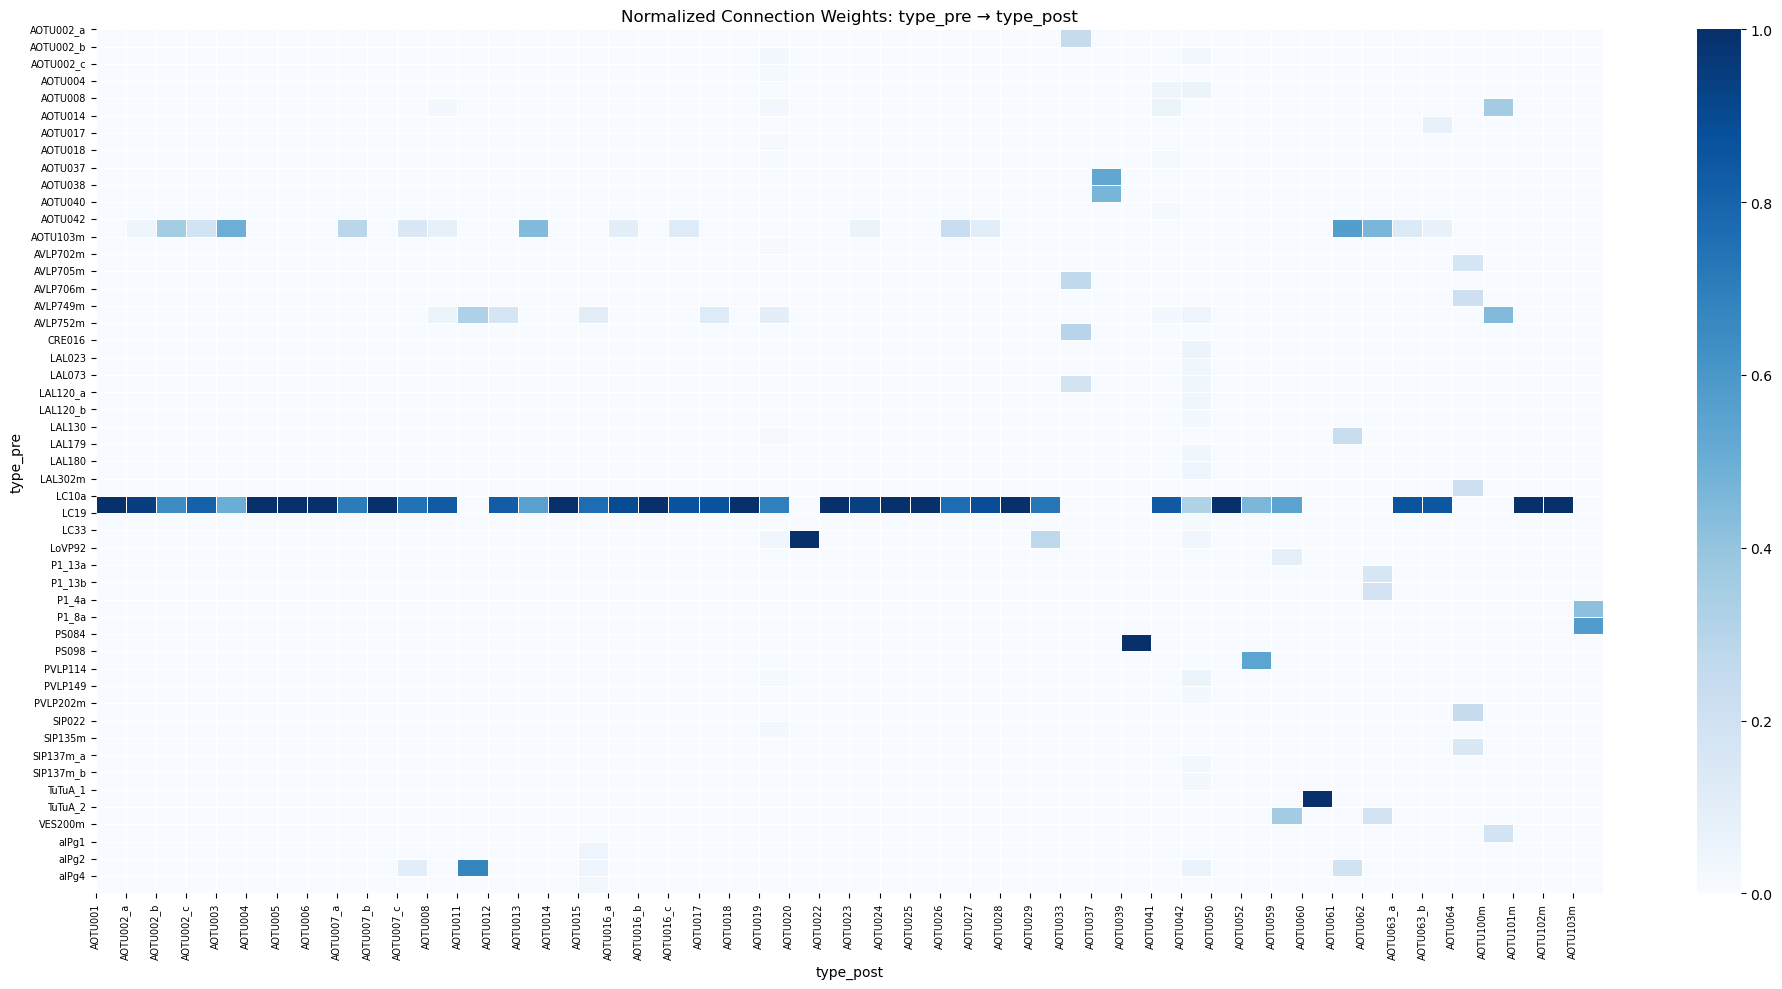

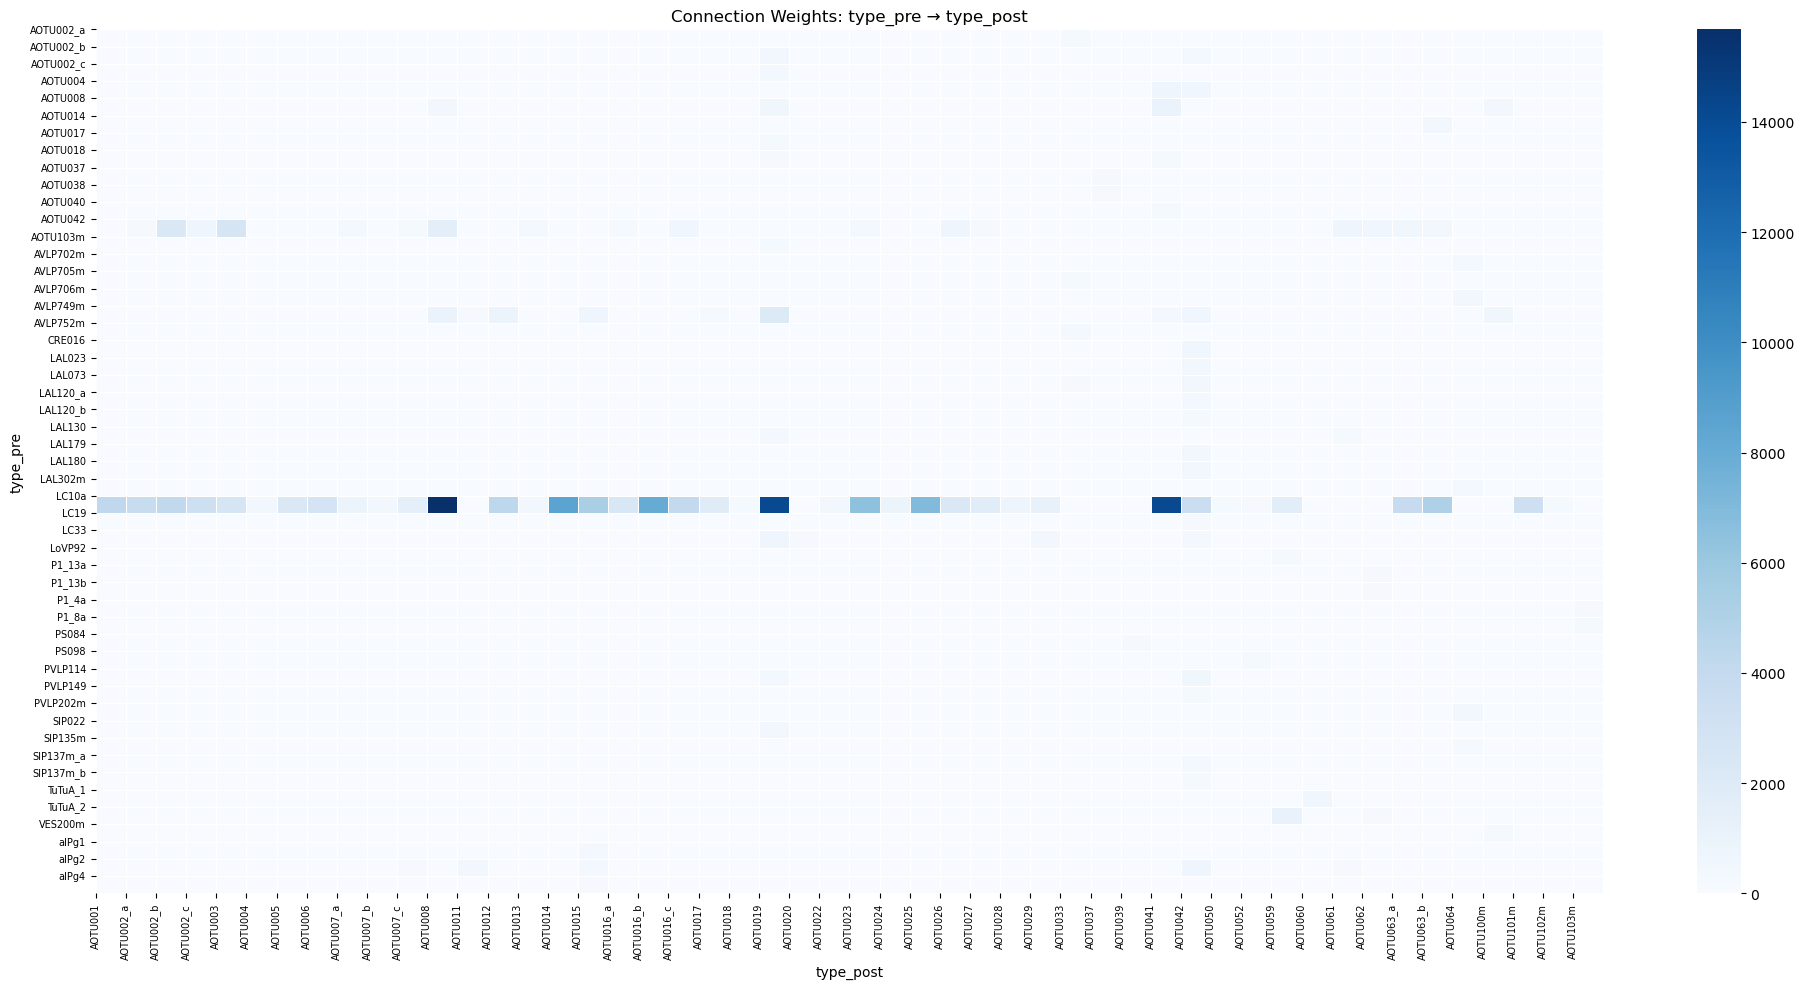

In [51]:
# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


# Real weights without normalizing
# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sb.heatmap(matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

## Effective connections

In [52]:
# neurons to get bodyIds for start and end
valid_nodes = set(G.nodes)

start_nodes = [nid for nid in start_nodes if nid in valid_nodes]
end_nodes = [nid for nid in end_nodes if nid in valid_nodes]



NameError: name 'G' is not defined

In [53]:
G = nx.DiGraph()
for _, row in conn_all_df.iterrows():
    G.add_edge(row['bodyId_pre'], row['bodyId_post'], weight=row['weight'])

In [54]:
all_paths = []

for source in start_nodes:
    for target in end_nodes:
        try:
            paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=4))  # optional: limit to 4 hops
            all_paths.extend(paths)
        except nx.NetworkXNoPath:
            continue


NameError: name 'start_nodes' is not defined

In [ ]:
print(f"Found {len(all_paths)} paths.")
for path in all_paths[:5]:
    print(" -> ".join(map(str, path)))

## Trying fru/dsx visualization

In [55]:
# conn_frudsx_AOTU_merge_df: grouped weights by (type_pre, type_post)
# frudsx_all_neurons: contains 'type' and 'fruDsx'

# Create a mapping from type → fruDsx
type_to_frudsx = frudsx_all_neurons.dropna(subset=['type', 'fruDsx']) \
                                   .drop_duplicates(subset='type') \
                                   .set_index('type')['fruDsx'].to_dict()

# Annotate pre-synaptic types with fruDsx label
conn_frudsx_AOTU_merge_df['fruDsx'] = conn_frudsx_AOTU_merge_df['type_pre'].map(type_to_frudsx)


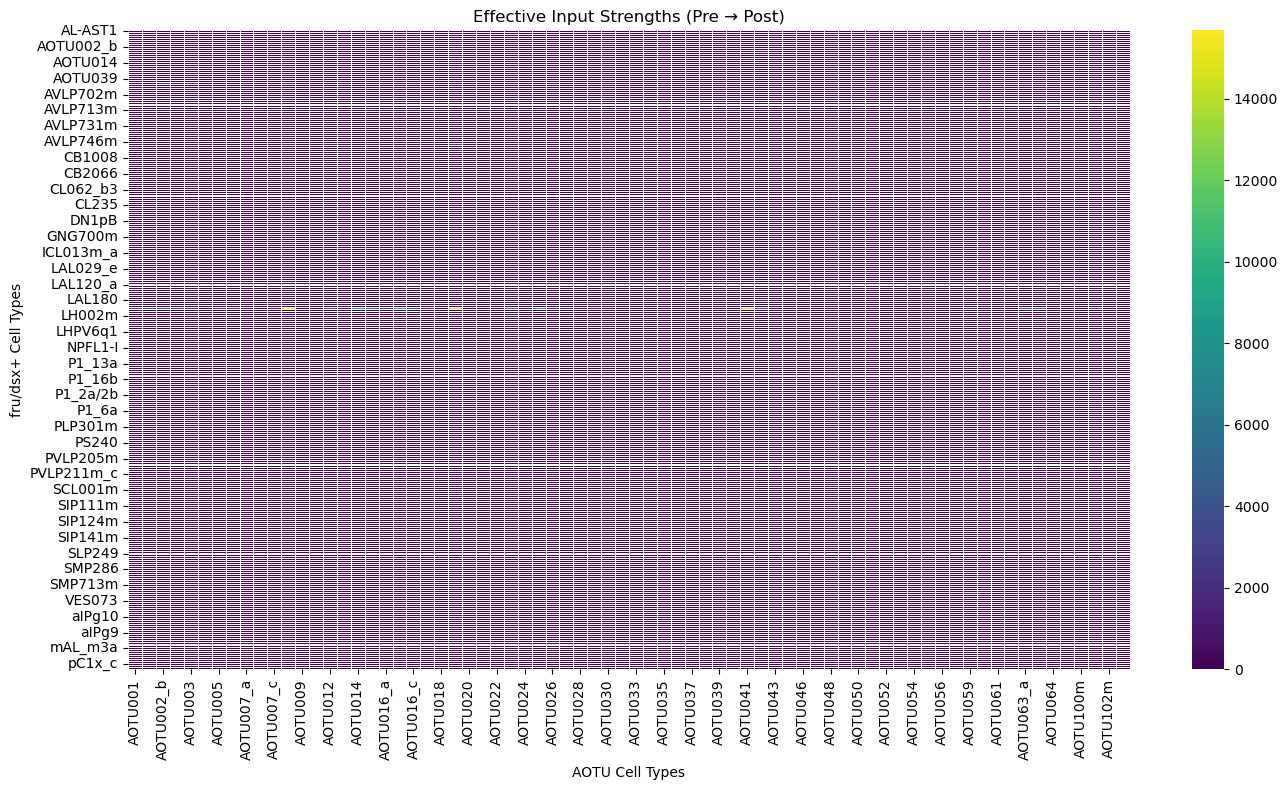

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot to heatmap format
pivot_df = conn_frudsx_AOTU_merge_df.pivot_table(
    index='type_pre',
    columns='type_post',
    values='weight',
    fill_value=0
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap='viridis', linewidths=0.5)
plt.title("Effective Input Strengths (Pre → Post)")
plt.xlabel("AOTU Cell Types")
plt.ylabel("fru/dsx+ Cell Types")
plt.tight_layout()
plt.show()


In [57]:
# Group by fruDsx and post type
grouped = conn_frudsx_AOTU_merge_df.groupby(['fruDsx', 'type_post'])['weight'].sum().reset_index()

import plotly.express as px
fig = px.bar(grouped, x='type_post', y='weight', color='fruDsx',
             title="Effective Inputs to AOTU by fru/dsx+ Identity",
             labels={'type_post': 'AOTU Cell Type', 'weight': 'Total Synaptic Weight'})

fig.update_layout(
    xaxis_tickangle=-45,
    xaxis=dict(
        tickfont=dict(size=7)  # 👈 Adjust font size here
    ),
    width=1200,
    height=600,
    margin=dict(b=150)
)

fig.show()

## If you want to Import dsx+ cells from xcel file

In [ ]:
# Load the Excel file
excel_path = "/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/AOTU_code/dsx_positive.xlsx"
df = pd.read_excel(excel_path)

# If the first column contains the neuron/cell type names
# and has a header, we assume it's in column index 0:
dsx_positive = df.iloc[:, 0].dropna().unique().tolist()

In [ ]:
print(f"Loaded {len(dsx_positive)} unique cell types:")
print(dsx_positive[:16])  # preview first 5

fetch neurons from data

In [ ]:
# Define list of cell types
# from the list above
dsx_types = ['pC1a', 'pC1b', 'pC1c', 'pC1d', 'pC1e', 'CB2375', 'CL313',
             'pC2la', 'AVLP567', 'AVLP569', 'AVLP570', 'AVLP568',
             'SMP029', 'DNp13', 'DNp37', 'AN_SMP_2']

# Fetch matching neurons
neurons_dsx_df, roi_dsx_df = fetch_neurons(NC(type=dsx_types))
#neurons_dsx_df

In [ ]:
dsx_celltypes = neurons_dsx_df['type'].unique()
dsx_celltypes

In [ ]:
neurons_AOTU_df[['bodyId', 'instance', 'type', 'fruDsx']]

In [ ]:
neurons_AOTU_df['fruDsx'].unique()